## Here we implement the algorithm for the recommendation tool. 

1) We import the data for our wardrobe
2) We import the prediction model
3) We implement the recommendation algorithm

In [1]:
import pandas as pd
import string
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm
from PIL import Image
import cv2
%matplotlib inline

from tensorflow.keras.models import load_model


# STEP 1: We import the data from our wardrobe

In [ ]:
# Function that takes a path of an image and returns its array
def preprocess_image_1(im_path):
    img_np = cv2.imread(im_path, cv2.IMREAD_COLOR)
    img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)
    im = cv2.resize(img_np, (224,224))
    im = im/255  
    return im

In [ ]:
# Here we want to make some recommendations using our wardrobe which has the following fomr:
# /test_wardrobe
#       /Tops
#               /image1withTops.jpg
#               /image2withTops.jpg
#               /image3withTops.jpg
#               /...
#       /Bottoms
#               /image1withBottoms.jpg
#               /image2withBottoms.jpg
#               /image3withBottoms.jpg
#               /...
#       /Shoes
#               /image1withShoes.jpg
#               /image2withShoes.jpg
#               /image3withShoes.jpg
#               /...
#       /...


# Then we use the first item from Tops and Bottoms and try to find the most compatible shoe. We predict for every different shoe and er shoe the top 3 scores.
# We repeat the same procedure for every category

In [25]:
### In this function we get a path of the wardrobe and we iterate in every folder and we import the images in a dictionary
# We create a function that takes as input a path of the wardrobe and loads the images to a data dictionary. We use the preprocess function to import he images.
# The data are saved to a dictionary with the categories as the keys and the images arrays as values.
categories = ["Tops", "Bottoms", "Shoes", "Bags", "Accessories", "Outwear", "Onepiece"]
def import_wardrobe(base_dir):

    # A dictionary to hold your image data per category
    data = {category: [] for category in categories}

    for category in categories:
        category_folder = os.path.join(base_dir, category)

        # Ensure the path exists
        if os.path.exists(category_folder):
            for img_file in os.listdir(category_folder):
                # Ensure dealing only with .jpg files or other image types
                if img_file.endswith(".jpg"):
                    img_path = os.path.join(category_folder, img_file)
                    # Use your image preprocessing function here
                    img = preprocess_image_1(img_path)
                    data[category].append(img)

    # Convert lists of images per category into numpy arrays
    for category in categories:
        data[category] = np.array(data[category])
        return data
# We define our path of the wardrobe
   
path = "/home/thanos/Desktop/Sustainable_fashion/data/test_images/test_wardrobe"
# We call the function to import the wardrobe from the path
data = import_wardrobe(path)
    

In [9]:
# First we load the prediction model
model = load_model("/home/thanos/Desktop/Sustainable_fashion/data/models/models_recommendation/model_Tops_Bottoms_Shoes_Outwear.h5")
# We can display the models summary to check the INPUTS of the model
model.summary()

Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tops (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bottoms (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Shoes (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                         

# STEP 2: Importing the prediction model we will use to get the scores

In [10]:
# First we load the prediction model
model = load_model("/home/thanos/Desktop/Sustainable_fashion/data/models/models_recommendation/model_Tops_Bottoms_Shoes_Outwear.h5")
# We can display the models summary to check the INPUTS of the model
model.summary()

Model: "model_59"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tops (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Bottoms (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Shoes (InputLayer)             [(None, 224, 224, 3  0           []                               
                                )]                                                         

# STEP 3: Implementing the recommendation algorithm 

In [26]:
x = data.keys()
print(x)

dict_keys(['Tops', 'Bottoms', 'Shoes', 'Bags', 'Accessories', 'Outwear', 'Onepiece'])


In [35]:
def recommend_outfits(data, categories, recommend_cat):
    # categories = ['Tops', 'Bottoms', 'Shoes','Outwear']
    # recommend_cat = 'Shoes'
    # Create an empty DataFrame to store the outfits and scores
    columns_list = categories + ['Score']
    outfits_df = pd.DataFrame(columns=columns_list)

    # Initial definition of the order of categories for the model
    full_category_order = ["Tops", "Bottoms", "Shoes", "Bags", "Accessories", "Outwear"]


     # Filter the category_order based on the categories provided
    category_order = [cat for cat in full_category_order if cat in categories]

    # Create a dictionary of first items for all categories except the recommendation category
    anchors = {cat: data[cat][0] for cat in categories if cat != recommend_cat}
    x = anchors.keys()
    print(x)

    anchors_exp = {cat: np.expand_dims(anchors[cat], axis=0) for cat in anchors}
    x = anchors_exp.keys()
    print(x) 

    # Predict scores for all items in the recommendation category
    for recommend_item in data[recommend_cat]:
        recommend_item_exp = np.expand_dims(recommend_item, axis=0)

        # Prepare input for the model in the correct order
        model_input = [anchors_exp[cat] if cat in anchors_exp else None for cat in categories]

        # We import the image the we want to recommend in the correct position
        if recommend_cat in category_order:
            model_input[category_order.index(recommend_cat)] = recommend_item_exp

        # # Displaying the image of the recommended item
        # plt.figure()
        # plt.imshow(np.squeeze(model_input[2]))
        # plt.title(f"Recommended {recommend_cat}")
        # plt.axis('off')
        # plt.show()

        # Filter out None values
        model_input = [inp for inp in model_input if inp is not None]
        # Get prediction score
        score = model.predict(model_input)[0]

        # Append the outfit and score to the dataframe
        outfit_data = dict(zip(categories, [anchors.get(cat, recommend_item) for cat in categories]))
        outfit_data['Score'] = score
        outfits_df = outfits_df.append(outfit_data, ignore_index=True)

    outfits_df['Score'] = outfits_df['Score'].astype(float)
    top_outfits_df = outfits_df.nlargest(2, 'Score')

    fig, axs = plt.subplots(2, len(categories), figsize=(5 * len(categories), 10))

    plt.suptitle(f'Top 2 Recommendations for {recommend_cat}', fontsize=16, fontweight='bold', y=1.02)


    for idx, (i, outfit) in enumerate(top_outfits_df.iterrows()):
        for col_idx, cat in enumerate(categories):
            axs[idx, col_idx].imshow(outfit[cat])
        axs[idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

dict_keys(['Bottoms', 'Shoes', 'Outwear'])
dict_keys(['Bottoms', 'Shoes', 'Outwear'])
1/1 [==============================] - 0s 27ms/step


<ipython-input-35-a946a7f05f0a>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outfits_df = outfits_df.append(outfit_data, ignore_index=True)
<ipython-input-35-a946a7f05f0a>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outfits_df = outfits_df.append(outfit_data, ignore_index=True)
<ipython-input-35-a946a7f05f0a>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outfits_df = outfits_df.append(outfit_data, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-35-a946a7f05f0a>:50: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outfits_df = outfits_df.append(outfit_data, ignore_index=True)


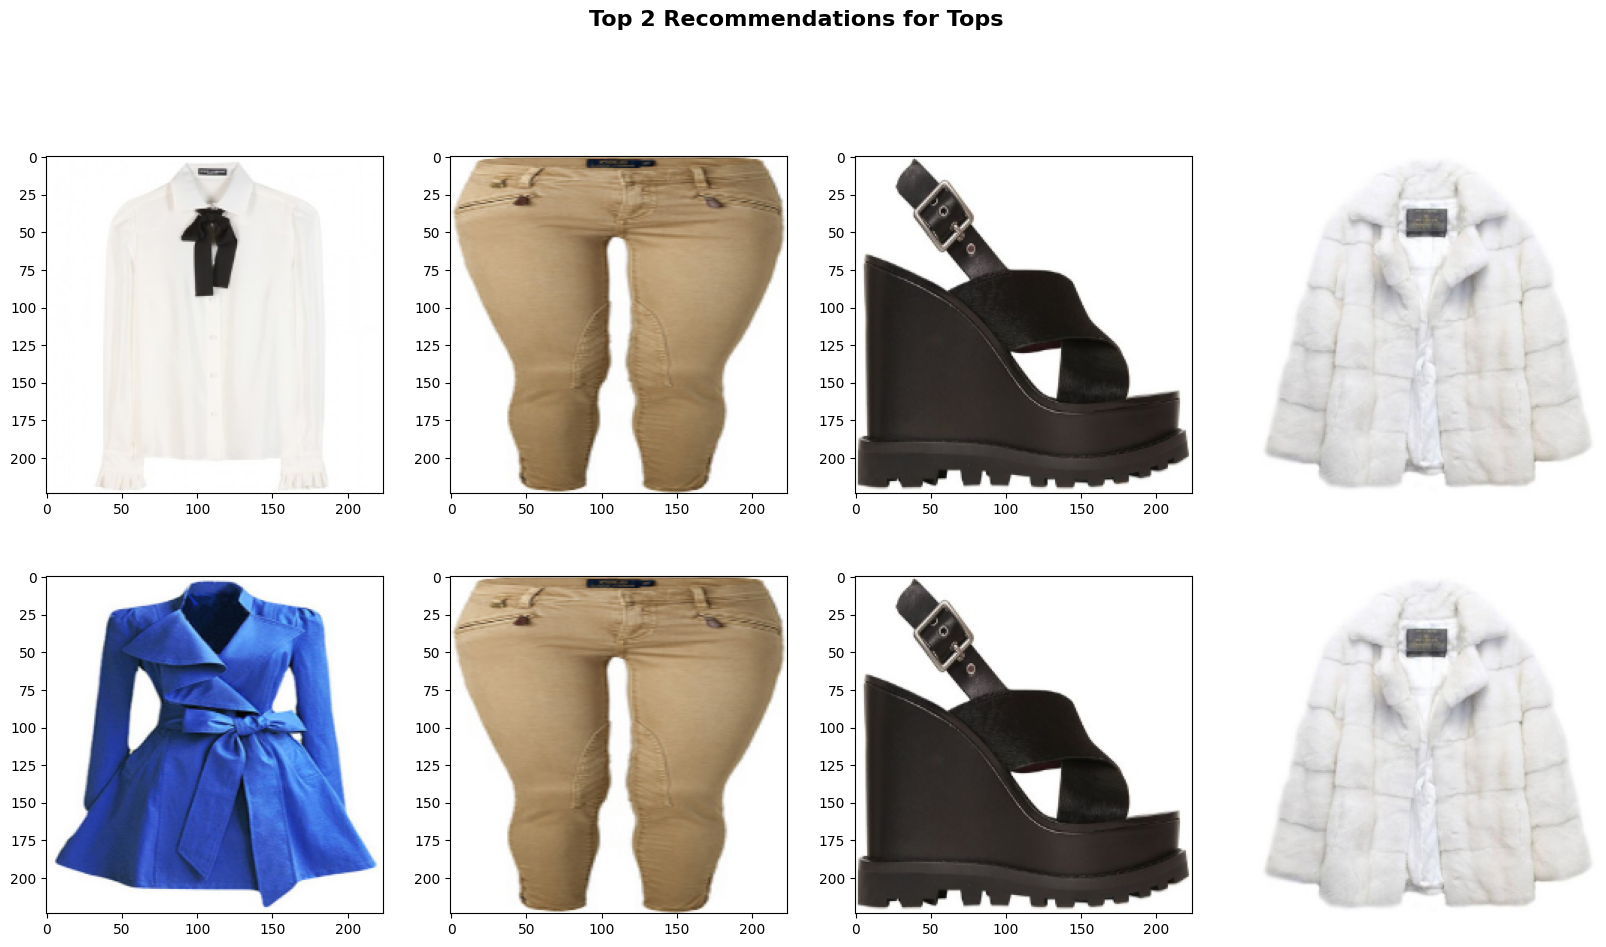

In [38]:
# We try to recommend one item form categories at a time, here we give as input the categories we use in the model(check model summary)
# and the category we want to get recommendation. The first items from the non recommendation categories are picked as default.
# ATTENTION: Be careful with outwear and outerwear spelling, we use outwear the most of times
recommend_outfits(data, ['Tops', 'Bottoms', 'Shoes','Outwear'], 'Tops')
